In [1]:
import scvi
import scanpy as sc
import pandas as pd
import numpy as np

Global seed set to 0


In [2]:
import matplotlib.pyplot as plt

In [3]:
import scanpy.external as sce

In [4]:
import torch
import pickle

In [5]:
import anndata

In [7]:
import os

In [8]:
from pyscenic.aucell import aucell
from pyscenic.genesig import GeneSignature
from pyscenic.aucell import create_rankings, enrichment

#### Load data

In [13]:
adata = sc.read('sarcoma.h5ad')

#### QC

In [17]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate mitochondrial genes as 'mt'
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL")) # annotate ribosomal genes as 'ribo'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)

In [22]:
adata = adata[adata.obs.total_counts > 300, :]
adata = adata[adata.obs.pct_counts_mt < 20, :]
adata = adata[adata.obs.total_counts < 40000, :]

#### Train model

In [28]:
adata = adata.copy()

In [29]:
scvi.model.SCVI.setup_anndata(adata, batch_key="batch")

In [30]:
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")

In [31]:
vae.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 53/53: 100%|██████████| 53/53 [14:42<00:00, 16.65s/it, loss=5.32e+03, v_num=1]


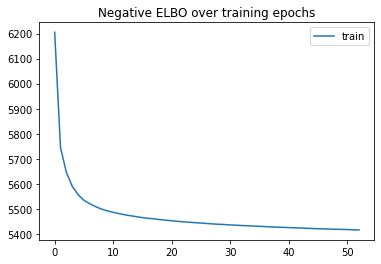

In [32]:
plt.plot(vae.history["elbo_train"], label="train")
#plt.plot(vae.history["elbo_validation"], label="val")
plt.title("Negative ELBO over training epochs")
#plt.ylim(1100, 1500)
plt.legend()

In [22]:
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    unlabeled_category="Unknown",
)

In [ ]:
lvae.train(25)

INFO     Training for 25 epochs.                                                             


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 21/25:  80%|████████  | 20/25 [56:51<14:03, 168.79s/it, loss=3.56e+03, v_num=1]

In [ ]:
plt.plot(lvae.history["elbo_train"], label="train")
#plt.plot(vae.history["elbo_validation"], label="val")
plt.title("Negative ELBO over training epochs")
#plt.ylim(1100, 1500)
plt.legend()

In [33]:
adata.obsm["X_scVI"] = vae.get_latent_representation(adata)

In [ ]:
adata.obsm["X_scANVI"] = lvae.get_latent_representation(adata)

In [34]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)

In [59]:
vae.save('sarcoma_tumor_all_cells_scvi', overwrite=True)

In [41]:
sc.tl.leiden(adata, resolution=0.2)

/itf-fi-ml/home/hermankn/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/itf-fi-ml/home/hermankn/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


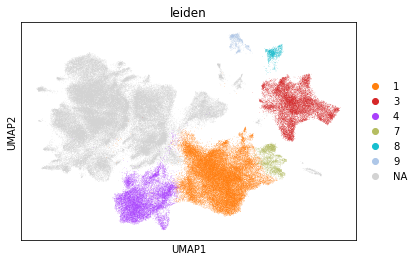

In [19]:
sc.pl.umap(adata, color='leiden', groups=['3', '8', '9', '1','4','7'])

In [20]:
leiden_type_dict = {'0' : 'CAFs', '1' : 'CAFs', '10' : 'CAFs', '11' : 'Plasmocytes', '12' : 'Osteoblastic', '13' : 'Osteoclasts', '2' : 'CAFs' , '5' : 'CAFs' , '6' : 'Endothelial cells'}

In [29]:
adata_immune = adata[adata.obs['leiden'].isin(['3', '8', '9', '1','4','7'])].copy()

AnnData object with n_obs × n_vars = 71033 × 21505
    obs: 'sample', 'patient', 'batch', 'tissue', 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden', 'celltypist_prediction', 'celltypist_majority_voting'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'dataset_colors', 'leiden', 'leiden_colors', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [22]:
adata_celltypist = adata_immune.copy()

In [23]:
import celltypist

In [24]:
sc.pp.normalize_total(adata_celltypist, target_sum=1e4)
sc.pp.log1p(adata_celltypist)

In [25]:
predictions = celltypist.annotate(adata_celltypist, model = 'Immune_All_Low.pkl', majority_voting = True)

🔬 Input data has 71033 cells and 21505 genes
🔗 Matching reference genes in the model
🧬 4384 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 20
🗳️ Majority voting the predictions
✅ Majority voting done!


In [26]:
adata_immune.obs['celltypist_prediction'] = predictions.predicted_labels['predicted_labels'][adata_immune.obs.index]#.to_numpy()
adata_immune.obs['celltypist_majority_voting'] = predictions.predicted_labels['majority_voting'][adata_immune.obs.index]#.to_numpy()

In [31]:
adata.obs['level2_cell_type'] = [adata_immune.obs.loc[x]['celltypist_majority_voting'] if x in adata_immune.obs.index else leiden_type_dict[y] for x,y in zip(adata.obs.index, adata.obs['leiden'])]

In [41]:
level1_level2_dict = {'B cells' : 'Lymphoid', 'CAFs' : 'Mesenchymal', 'CD16+ NK cells' : 'Lymphoid', 'CD16- NK cells' : 'Lymphoid',
'Classical monocytes' : 'Myeloid', 'DC1' : 'Myeloid', 'DC2' : 'Myeloid', 'Endothelial cells' : 'Mesenchymal',
'Fibroblasts' : 'Mesenchymal', 'Macrophages' : 'Myeloid', 'Memory B cells' : 'Lymphoid', 'Migratory DCs' : 'Myeloid',
'NKT cells' : 'Lymphoid', 'Non-classical monocytes' : 'Myeloid', 'Osteoblastic' : 'Mesenchymal',
'Osteoclasts' : 'Myeloid', 'Plasma cells' : 'Lymphoid', 'Plasmocytes' : 'Lymphoid', 'Regulatory T cells' : 'Lymphoid',
'Tcm/Naive cytotoxic T cells' : 'Lymphoid', 'Tcm/Naive helper T cells' : 'Lymphoid',
'Tem/Effector helper T cells' : 'Lymphoid', 'Tem/Trm cytotoxic T cells' : 'Lymphoid'}

In [42]:
adata.obs['level1_cell_type'] = [level1_level2_dict[x] for x in adata.obs['level2_cell_type']]

... storing 'level1_cell_type' as categorical


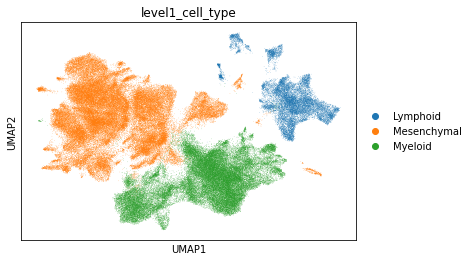

In [44]:
sc.pl.umap(adata, color='level1_cell_type')#, save='level1_cell_type_sarcoma.pdf')

#### Sankey

In [62]:
level1_level2_df = sc.get.obs_df(adata,keys=['level1_cell_type', 'level2_cell_type'])
level1_level2_df = pd.crosstab(level1_level2_df['level1_cell_type'], level1_level2_df['level2_cell_type']).T

In [63]:
level2_color_dict = dict(np.array([adata.obs['level2_cell_type'].cat.categories, adata.uns['level2_cell_type_colors']]).T)

In [64]:
level1_color_dict = dict(np.array([adata.obs['level1_cell_type'].cat.categories, adata.uns['level1_cell_type_colors']]).T)

In [65]:
from utils.sankey_diagram import sankey_diagram

In [66]:
order_cell_types = ['Mesenchymal', 'Myeloid', 'Lymphoid']

In [67]:
level1_level2_df = level1_level2_df[order_cell_types]

In [68]:
a_sort = list(np.flip(order_cell_types))

In [69]:
b_sort = list(np.flip((level1_level2_df.index[np.argsort(-(level1_level2_df * [10e100, 10e15, 10e1]).sum(axis=1).to_numpy())])))

In [71]:
sankey_diagram(adata.obs[['level1_cell_type', 'level2_cell_type']].to_numpy(), level1_color_dict, level2_color_dict, figsize=(8,12), a_sort=a_sort, b_sort=b_sort, save_path=os.path.join(figures_dir, 'sankey_level1_level2.pdf'))

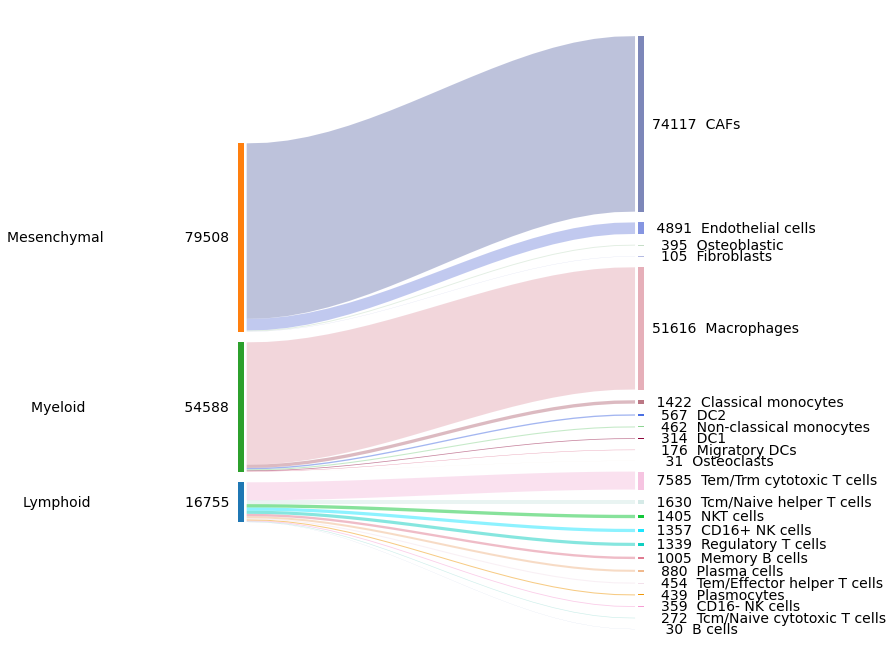

In [72]:
sankey_diagram(adata.obs[['level1_cell_type', 'level2_cell_type']].to_numpy(), level1_color_dict, level2_color_dict, a_sort=a_sort, figsize=(8,12), b_sort=b_sort, show=True)